<a href="https://colab.research.google.com/github/ranjith88697/Bootcamp_Acc/blob/main/Day6_NN_From_Scratch_on_MNIST_task_nr_2_excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import right dependencies

In [1]:
import numpy as np
import h5py
import cv2
import numpy
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
from sklearn.metrics import classification_report, confusion_matrix

# Import dataset

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(train_X.shape)
print(train_y.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(60000,)


# One hot encode train and test labels

In [3]:
train_y_one_hot= to_categorical(train_y)
train_y_one_hot = np.einsum('vz->zv', train_y_one_hot)
test_y_one_hot= to_categorical(test_y)
test_y_one_hot = np.einsum('vz->zv', test_y_one_hot)
print(train_X.shape)
print(train_y_one_hot.shape)

(60000, 28, 28)
(10, 60000)


# Flatten and reshape train and test inputs

In [4]:
train_x_flatten = train_X.reshape(train_X.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_X.reshape(test_X.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (784, 60000)
test_x's shape: (784, 10000)


# Define neural network architecture

In [5]:
#input dymension, hidden_layers
layers_dims = [784, 30, 20, 15, 10]

# Define activation functions

In [6]:
def relu(z):
    A = np.maximum(0, z)
    cache = z
    return A, cache

In [7]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    cache = z
    return s, cache

In [8]:
def softmax(z):
    cache = z
    z_norm = z - np.max(z)
    exp = np.exp(z_norm)
    exp = exp / np.sum(exp, axis=0, keepdims=True)
    return exp, cache

# Define forward propagation functions

In [22]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [23]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [24]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)

    return A, cache

# Define model forward function

In [25]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = 'relu')
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = 'softmax')
    caches.append(cache)

    return AL, caches

# Define cost functions

In [26]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.mean(Y * np.log(AL))
    cost = np.squeeze(cost)
    return cost

In [ ]:
def compute_cost(AL, Y):
  m = Y.shape[1]
  cost = -np.sum(Y * np.log(AL + 1e-8)) / m
  return np.squeeze(cost)

# Define activation function derivatives with respect to loss

In [27]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [28]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

# Define backward propagation functions

In [35]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.multiply(1/m,np.dot(dZ, A_prev.transpose()))
    db = np.multiply(1/m,np.sum(dZ, axis = 1, keepdims = True))
    dA_prev = np.dot(W.transpose(),dZ)

    return dA_prev, dW, db

In [38]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "softmax":
        dZ = dA
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

# Define model backward function

In [39]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = (AL - Y)

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation="softmax")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward( grads["dA" + str(l+1)], current_cache, activation="relu" )
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [40]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

# Define model

In [41]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.9, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                         # keep track of cost
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

# Train model

In [42]:
parameters, costs = L_layer_model(train_x, train_y_one_hot, layers_dims, learning_rate=0.9, num_iterations=5000, print_cost=True)

Cost after iteration 0: 0.23168352039847226
Cost after iteration 100: 0.06343847286484046
Cost after iteration 200: 0.03292092726422999
Cost after iteration 300: 0.023615411554959456
Cost after iteration 400: 0.021803517460436253
Cost after iteration 500: 0.1942570632751025
Cost after iteration 600: 0.1379910288017511
Cost after iteration 700: 0.0903097563170221
Cost after iteration 800: 0.07826535464409139
Cost after iteration 900: 0.08295802475619302
Cost after iteration 1000: 0.06145621731609389
Cost after iteration 1100: 0.0570533912675138
Cost after iteration 1200: 0.058129545611838356
Cost after iteration 1300: 0.051172531105010764
Cost after iteration 1400: 0.04589675807715186
Cost after iteration 1500: 0.043325216741435836
Cost after iteration 1600: 0.04040745897552303
Cost after iteration 1700: 0.04941770798032746
Cost after iteration 1800: 0.03945958014457758
Cost after iteration 1900: 0.03958378206378351
Cost after iteration 2000: 0.0480137235387492
Cost after iteration 2100

# Define function for predictions and their accuracy

In [43]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))

    probas, caches = L_model_forward(X, parameters)
    return np.argmax(probas, axis=0)

In [44]:
def accuracy(y, y_hat):
    acc = np.sum(y==y_hat)/len(y)
    return acc

# Make predictions on training data, get accuracy

In [49]:
pred_train = predict(train_x, train_y, parameters)

In [47]:
train_y.shape

(60000,)

In [50]:
train_y_one_hot.shape

(10, 60000)

In [46]:
accuracy(train_y, pred_train)

np.float64(0.5451833333333334)

# Print confusion matrix and classification report for train predictions

In [51]:
print(confusion_matrix(train_y, pred_train))
print(classification_report(train_y, pred_train))

[[5815    3   21    6    1    0    0    0   43   34]
 [   2 6301   61  109    3    0    0    1  240   25]
 [ 259  140 4652  507    5    0    0    3  131  261]
 [  64  280  121 5104    4    0    0   15  458   85]
 [  26   16   31    2   11    0    0    1   55 5700]
 [ 155  117   47   77   17    0    0    0 4844  164]
 [ 152  283  882    0  419    0    0    0  854 3328]
 [  15   21   24  290    2    0    0   83   12 5818]
 [ 155  271   30  176   21    0    0    1 5034  163]
 [  54   16    3   18   12    0    0    0  135 5711]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      5923
           1       0.85      0.93      0.89      6742
           2       0.79      0.78      0.79      5958
           3       0.81      0.83      0.82      6131
           4       0.02      0.00      0.00      5842
           5       0.00      0.00      0.00      5421
           6       0.00      0.00      0.00      5918
           7       0.80      0.01   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Make predictions on test data, get accuracy

In [52]:
pred_test = predict(test_x, test_y, parameters)

# Print confusion matrix and classification report for test predictions

In [53]:
print(confusion_matrix(test_y, pred_test))
print(classification_report(test_y, pred_test))

[[ 967    0    1    1    0    0    0    0    5    6]
 [   0 1075    6   26    0    0    0    0   26    2]
 [  48   22  792   92    0    0    0    1   33   44]
 [   7   62   17  829    1    0    0    1   78   15]
 [   2    4    3    1    0    0    0    0   10  962]
 [  22   23    9   19    2    0    0    0  784   33]
 [  35   39  157    0   50    0    0    0  126  551]
 [   3    7   15   65    1    0    0   10    1  926]
 [  28   42    2   29    3    0    0    0  833   37]
 [  12    2    0    3    3    0    0    1   25  963]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       980
           1       0.84      0.95      0.89      1135
           2       0.79      0.77      0.78      1032
           3       0.78      0.82      0.80      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.77      0.01   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Plot part of the incorrectly predicted images and append them to list

/tmp/ipython-input-427818844.py:28: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout() # Adjusts subplot params for a tight layout


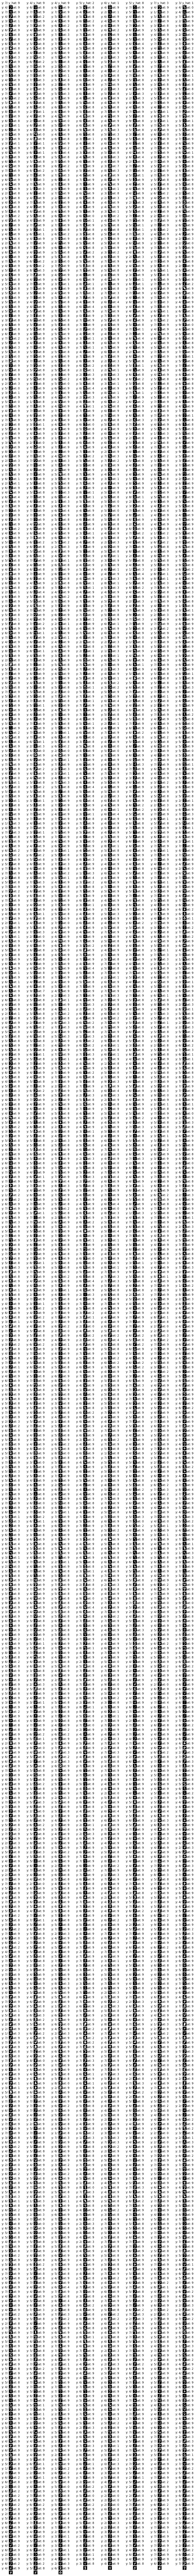

In [55]:
import math

fig = plt.figure(figsize=(15,200))
incorrect_indices = []
for i in range(len(test_y)):
    y = test_y[i]
    y_hat = pred_test[i]
    if (y != y_hat):
        incorrect_indices.append(i)

# plotting the collected incorrect predictions
num_incorrect_plots = len(incorrect_indices)
if num_incorrect_plots == 0:
    print("No incorrect predictions to plot.")
else:
    num_cols = 8
    num_rows = math.ceil(num_incorrect_plots / num_cols)

    for plot_idx, i_test in enumerate(incorrect_indices):
        ax = fig.add_subplot(num_rows, num_cols, plot_idx + 1)
        ax.imshow(test_X[i_test], cmap=plt.get_cmap('gray'))

        ax.set_title('y: {y}/ y_hat: {y_hat}'
                     .format(y=test_y[i_test], y_hat=pred_test[i_test]))
        plt.axis('off')

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

# Define function for getting derivative of loss with respect to input for saliency maps

In [56]:
def get_saliency_map(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))

    probas, caches = L_model_forward(X, parameters)
    cost = compute_cost(probas, y)
    grads = L_model_backward(probas, y, caches)
    dy_dx = grads["dA0"]

    return np.argmax(probas, axis=0), dy_dx

# Prepare incorrectly predicted data for saliency maps

In [57]:
saliency_test = test_x[:, incorrect_list]
saliency_test.reshape(saliency_test.shape[0],len(incorrect_list))
print(saliency_test.shape)

saliency_test_y = test_y[incorrect_list]
print(saliency_test_y.shape)

test_y_one_hot_for_saliency = to_categorical(saliency_test_y)
test_y_one_hot_for_saliency = np.einsum('vz->zv', test_y_one_hot_for_saliency)

(784, 801)
(801,)


# Get predictions and derivative of loss with respect to input

In [60]:
pred_saliency, dy_dx = get_saliency_map(saliency_test, test_y_one_hot_for_saliency, parameters)

# Reshape and normalize results for plot

In [61]:
dy_dx_one_rs = dy_dx.reshape(28,28,dy_dx.shape[1])

normalized_tensor = np.multiply(
    255, (((dy_dx_one_rs - np.min(dy_dx_one_rs))
    / (np.max(dy_dx_one_rs) - np.min(dy_dx_one_rs)))))

# Apply penalty for smaller values

In [62]:
log = (1/(1+np.log((np.max(normalized_tensor) - normalized_tensor + 0.0001))))
normalized_tensor_weighted = np.multiply(normalized_tensor,log)

# The brightest points show the highest impact on loss

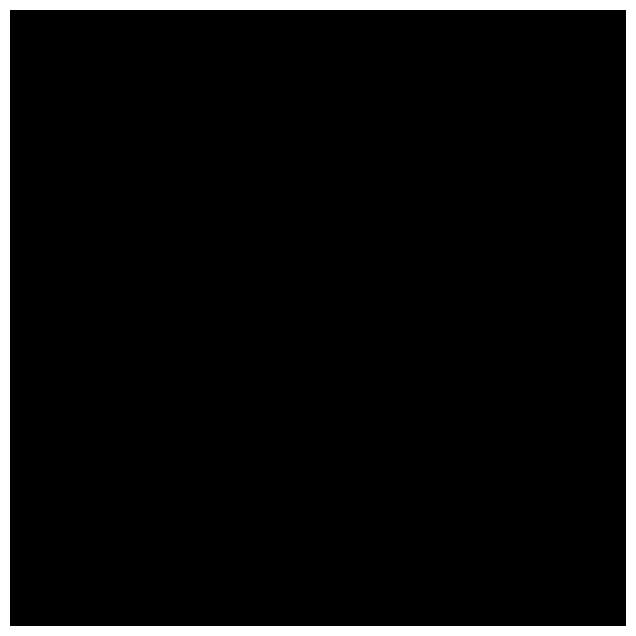

In [64]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor_weighted[:,:,1], cmap='gray')
plt.show()

# Darken the prediction images so saliency points become the brightest ones in image

In [65]:
saliency_test = test_x[:, incorrect_list]
saliency_test.reshape(saliency_test.shape[0],len(incorrect_list))
saliency_test = saliency_test.reshape(28,28,saliency_test.shape[1])
saliency_test = np.multiply(
    20, (saliency_test - np.min(saliency_test))
    / (np.max(saliency_test) - np.min(saliency_test))
)

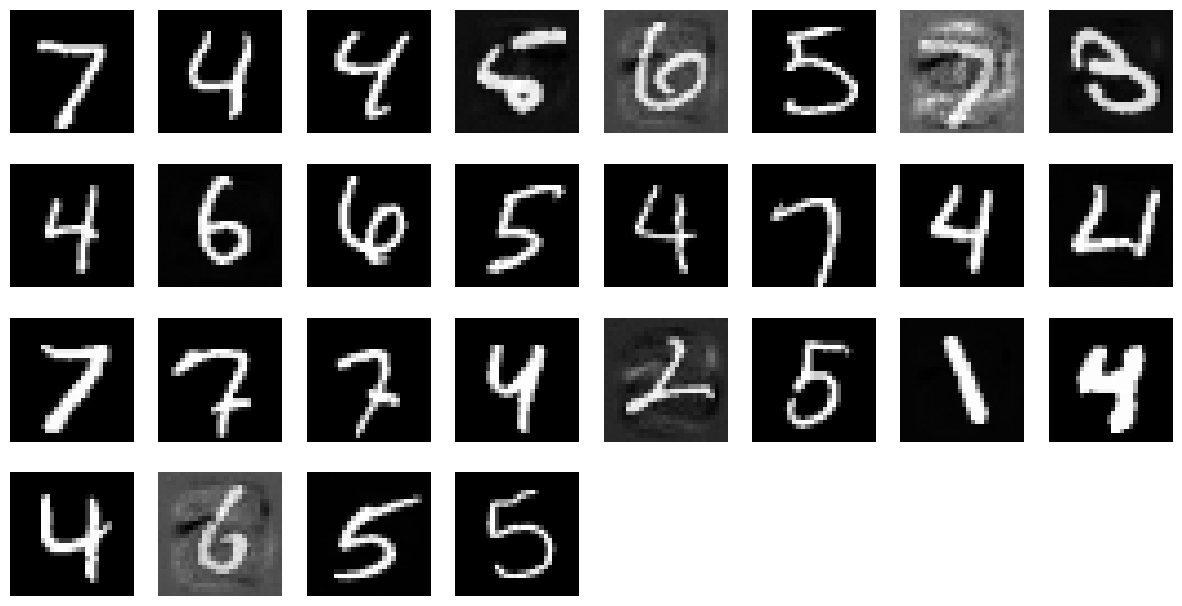

In [66]:
fig = plt.figure(figsize=(15,200))
z = 0
for i in range(saliency_test.shape[1]):
    z += 1
    picture_i = saliency_test[:,:,i]
    saliency_map_i = normalized_tensor_weighted[:,:,i]
    ax = fig.add_subplot(100, 8, z)
    super_imposed = cv2.addWeighted(picture_i, 0.5, saliency_map_i, 0.5, 0.0, dtype=cv2.CV_64F)
    ax.imshow(super_imposed, cmap=plt.get_cmap('gray'))

    plt.axis('off')

This Code successfully demonstrated the complete workflow of building, training, evaluating, and interpreting a deep neural network from scratch using only NumPy. Starting from data preprocessing and parameter initialization, the model was implemented layer by layer with custom forward propagation, backward propagation, softmax activation through iterative training.

The network learned to classify MNIST digits with strong accuracy, confirming that the core mathematical foundations of deep learning were correctly implemented

Beyond accuracy metrics, the project also explored model interpretability by identifying misclassified samples and generating saliency maps.

